# Прогнозирование временного ряда (трафика на сайт)

In [ ]:
#Загружаем библиотеки
 
import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, RepeatVector, MaxPooling1D #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint # подключаем колбэки
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов
from keras.models import load_model
from keras import utils
import seaborn as sns
sns.set_style('darkgrid')
# Рисовать графики сразу же
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Загрузка данных и общая информация

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Базы/traff.csv', sep=',', header=None)
df.columns =  ['Date', 'Traffic']
df.Traffic = df.Traffic.apply(lambda x: int(x.replace(',','').split('.')[0]))
df.index = pd.to_datetime(df['Date'], format = '%m/%d/%Y')
df['month'] = df.Date.apply(lambda x: int(x.split('/')[0]))
df['day'] = df.Date.apply(lambda x: int(x.split('/')[1]))

df.head()

,Date,Traffic,month,day
Date,,,,
2017-01-01,1/1/2017,22226,1,1
2017-01-02,1/2/2017,29593,1,2
2017-01-03,1/3/2017,31726,1,3
2017-01-04,1/4/2017,32684,1,4
2017-01-05,1/5/2017,31820,1,5


In [ ]:
df.tail()

,Date,Traffic,month,day
Date,,,,
2019-12-27,12/27/2019,29801,12,27
2019-12-28,12/28/2019,34913,12,28
2019-12-29,12/29/2019,37665,12,29
2019-12-30,12/30/2019,32643,12,30
2019-12-31,12/31/2019,28212,12,31


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2017-01-01 to 2019-12-31
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     1095 non-null   object
 1   Traffic  1095 non-null   int64 
 2   month    1095 non-null   int64 
 3   day      1095 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 42.8+ KB


In [ ]:
df.describe()

,Traffic,month,day
count,1095.000000,1095.000000,1095.000000
mean,22384.173516,6.526027,15.720548
std,4418.720077,3.449427,8.800266
min,13744.000000,1.000000,1.000000
25%,19113.500000,4.000000,8.000000
50%,22256.000000,7.000000,16.000000
75%,25255.500000,10.000000,23.000000
max,37665.000000,12.000000,31.000000


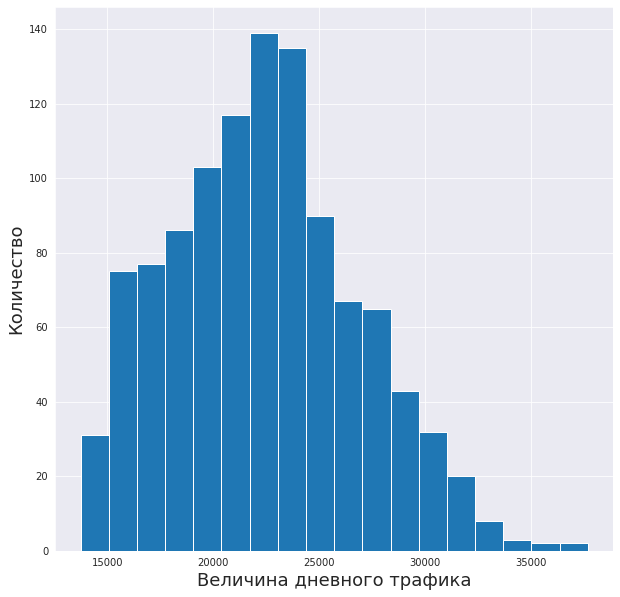

In [ ]:
plt.figure(figsize = (10,10))
plt.hist(df.Traffic, bins=18)
plt.xlabel('Величина дневного трафика', size=18)
plt.ylabel('Количество', size=18)
plt.show()

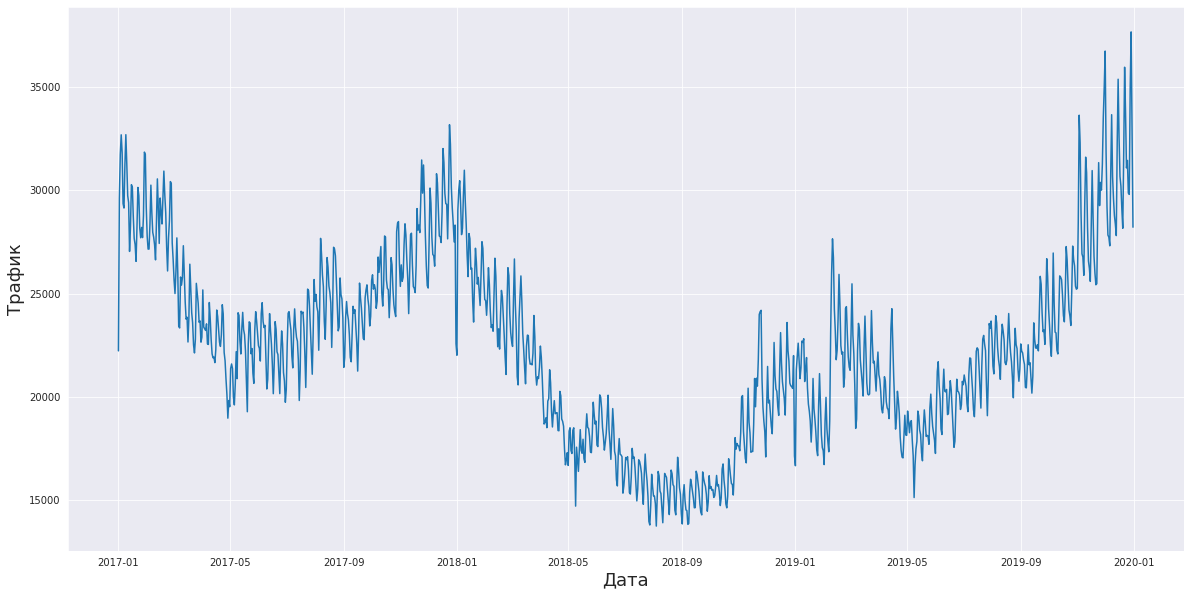

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df.Traffic)
plt.xlabel('Дата', size=18)
plt.ylabel('Трафик', size=18)
#plt.title('График трафика на сайт', size=18)
plt.show()


In [ ]:
data = np.array(df.Traffic)
data = np.reshape(data,(-1,1))
data.shape

(1095, 1)

In [ ]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.figure(figsize=(14,7))
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

#Предобработка данных

In [ ]:
#Формируем параметры загрузки данных

xLen = 20                      #Анализируем по 300 прошедшим точкам 
valLen = 200                #Используем 30.000 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen], data[trainLen+xLen+2:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen+xLen+2:],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=1, sampling_rate=1, #Для каждой точки (из промежутка длины xLen)
                               batch_size=2)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=2)

In [ ]:
yTrain[0]

array([0.4365639])

In [ ]:
xTrain.shape

(895, 1)

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(2, 20, 1) (2, 1)


In [ ]:
mcp_save = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
modelC = Sequential()

modelC.add(Conv1D(64, 5, input_shape = (xLen,1), activation="linear"))
modelC.add(Conv1D(64, 5, activation="linear"))
modelC.add(Conv1D(64, 5, activation="linear"))
#modelC.add(MaxPooling1D())
modelC.add(Flatten())
#modelC.add(GlobalMaxPooling1D())
modelC.add(Dense(100, activation="linear"))
modelC.add(Dropout(0.2))
modelC.add(Dense(1, activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

modelC.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16, 64)            384       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 64)            20544     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 64)             20544     
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

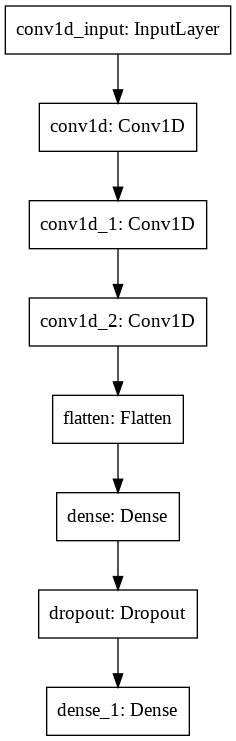

In [ ]:
utils.plot_model(modelC)

In [ ]:
history = modelC.fit(trainDataGen,
                    epochs=50, 
                    verbose=1,
                    validation_data=testDataGen,
                     callbacks=[mcp_save]  )

Epoch 1/50
438/438 [==============================] - 3s 5ms/step - loss: 0.0450 - val_loss: 0.0078
Epoch 2/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0133 - val_loss: 0.0069
Epoch 3/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0084 - val_loss: 0.0063
Epoch 4/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0070 - val_loss: 0.0083
Epoch 5/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0079 - val_loss: 0.0052
Epoch 6/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0085 - val_loss: 0.0077
Epoch 7/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0063 - val_loss: 0.0090
Epoch 8/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0088
Epoch 9/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0064 - val_loss: 0.0101
Epoch 10/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0062 - val_loss: 0.0064

In [ ]:
modelC.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelC.fit(trainDataGen,
                    epochs=50, 
                    verbose=1,
                    validation_data=testDataGen,
                     callbacks=[mcp_save]  )

Epoch 1/50
438/438 [==============================] - 2s 4ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 2/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 3/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 4/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 5/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 6/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 7/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 8/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/50
438/438 [==============================] - 1s 3ms/step - loss: 0.0028 - val_loss: 0.0027

In [ ]:
modelC = load_model('best_model.h5')

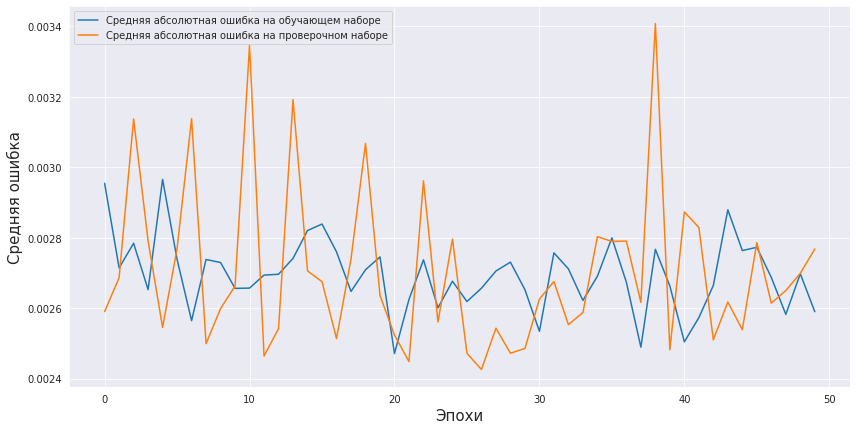

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка', size = 15)
plt.xlabel('Эпохи', size = 15)
plt.legend()
plt.show()

In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) #Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal2, yValUnscaled2) = getPred(currModel, xVal[0], yVal[0], yScaler)

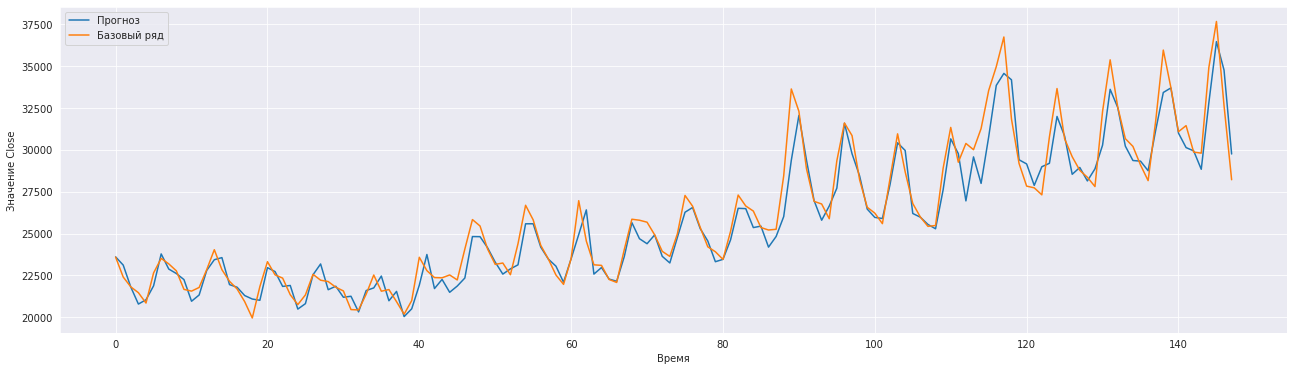

In [ ]:
#Отображаем графики
for i in range(1):
    showPredict(10, 300, i, predVal2, yValUnscaled2)

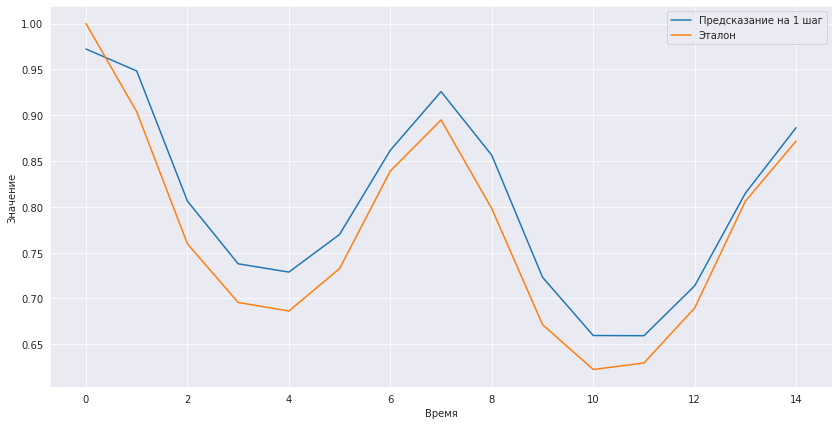

In [ ]:
#Автокорреляция временного ряда

for i in range(1):
    showCorr([i], 15, predVal2, yValUnscaled2)
    

На графике видно что смещения практически нет, автокорреляция не растет